In [32]:
import sys
sys.path.append("../src/")
import warnings
warnings.filterwarnings("ignore")

from eddies_detection import  get_traj_with_parcels, get_traj_with_scipy, find_eddies, find_eddies2, optimized_streamline
from plot_tools import StreamPlot
import numpy as np

d0 = 0
date_len = 10
stream_data_fname = "../data/data.nc"
runtime = 800   
delta_time = 5
particle_grid_step = 2

In [3]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 15]

## Compute the list of path

In [33]:
list_path = []

for di in range(date_len):
    b = get_traj_with_scipy(d0+di, runtime, delta_time, particle_grid_step, stream_data_fname)
    
    bb = find_eddies(b)
    list_path.append(bb)

5% 10% 15% 20% 25% 30% 35% 40% 45% 50% 55% 60% 65% 70% 75% 80% 85% 90% 95% 
5% 10% 15% 20% 25% 30% 35% 40% 45% 50% 55% 60% 65% 70% 75% 80% 85% 90% 95% 
5% 10% 15% 20% 25% 30% 35% 40% 45% 50% 55% 60% 65% 70% 75% 80% 85% 90% 95% 
5% 10% 15% 20% 25% 30% 35% 40% 45% 50% 55% 60% 65% 70% 75% 80% 85% 90% 95% 
5% 10% 15% 20% 25% 30% 35% 40% 45% 50% 55% 60% 65% 70% 75% 80% 85% 90% 95% 
5% 10% 15% 20% 25% 30% 35% 40% 45% 50% 55% 60% 65% 70% 75% 80% 85% 90% 95% 
5% 10% 15% 20% 25% 30% 35% 40% 45% 50% 55% 60% 65% 70% 75% 80% 85% 90% 95% 
5% 10% 15% 20% 25% 30% 35% 40% 45% 50% 55% 60% 65% 70% 75% 80% 85% 90% 95% 
5% 10% 15% 20% 25% 30% 35% 40% 45% 50% 55% 60% 65% 70% 75% 80% 85% 90% 95% 
5% 10% 15% 20% 25% 30% 35% 40% 45% 50% 55% 60% 65% 70% 75% 80% 85% 90% 95% 


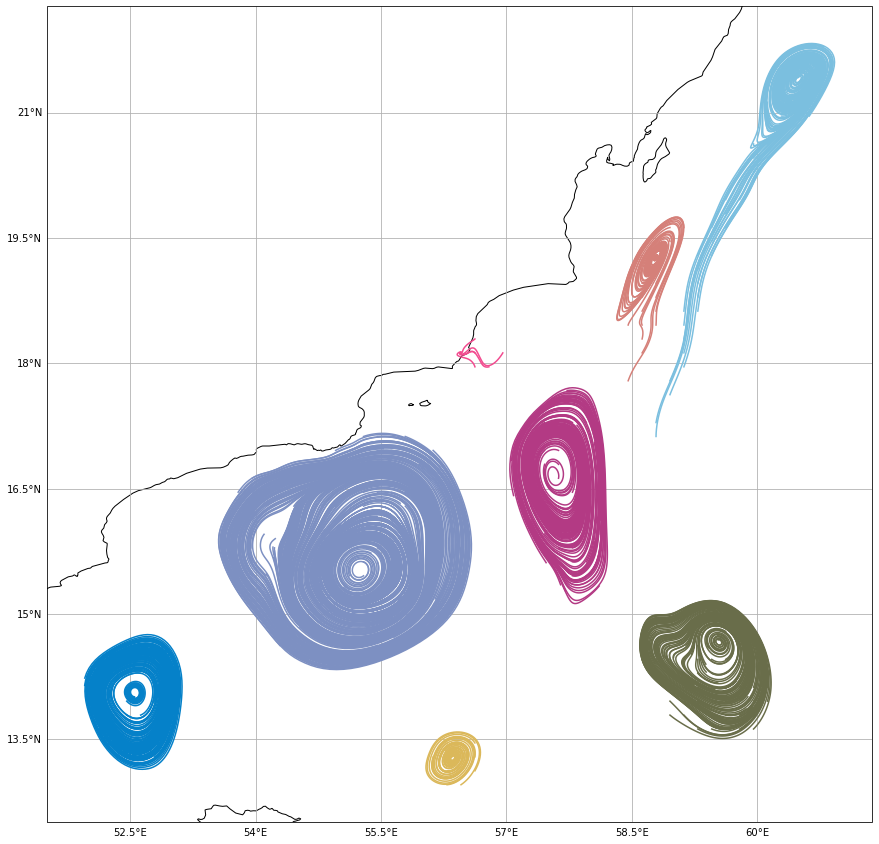

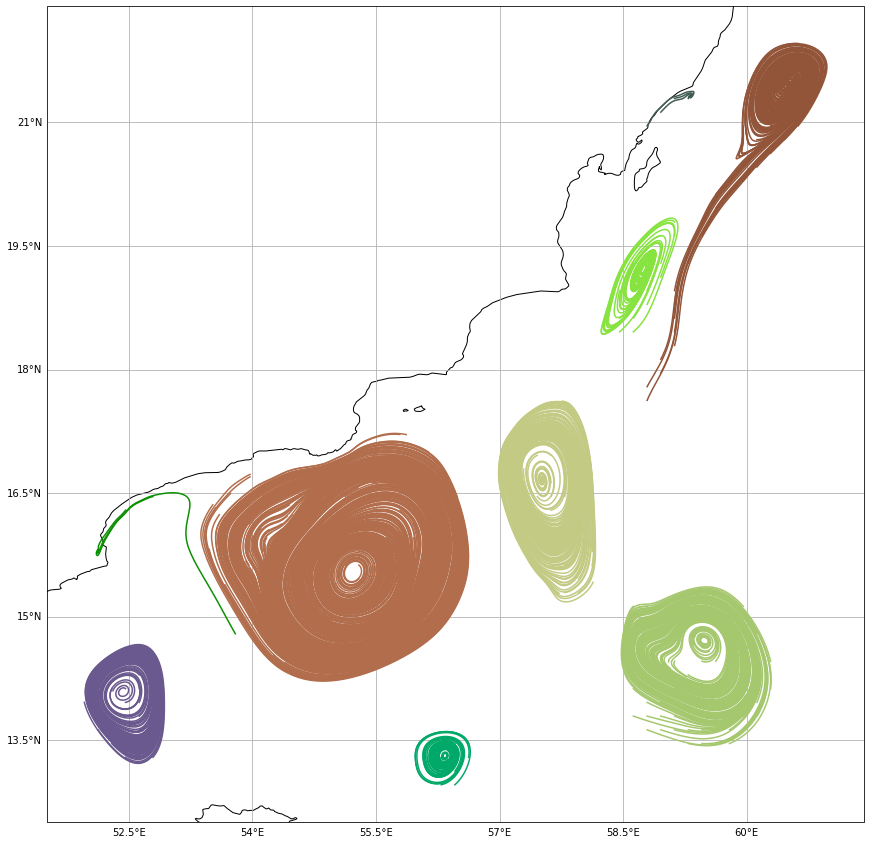

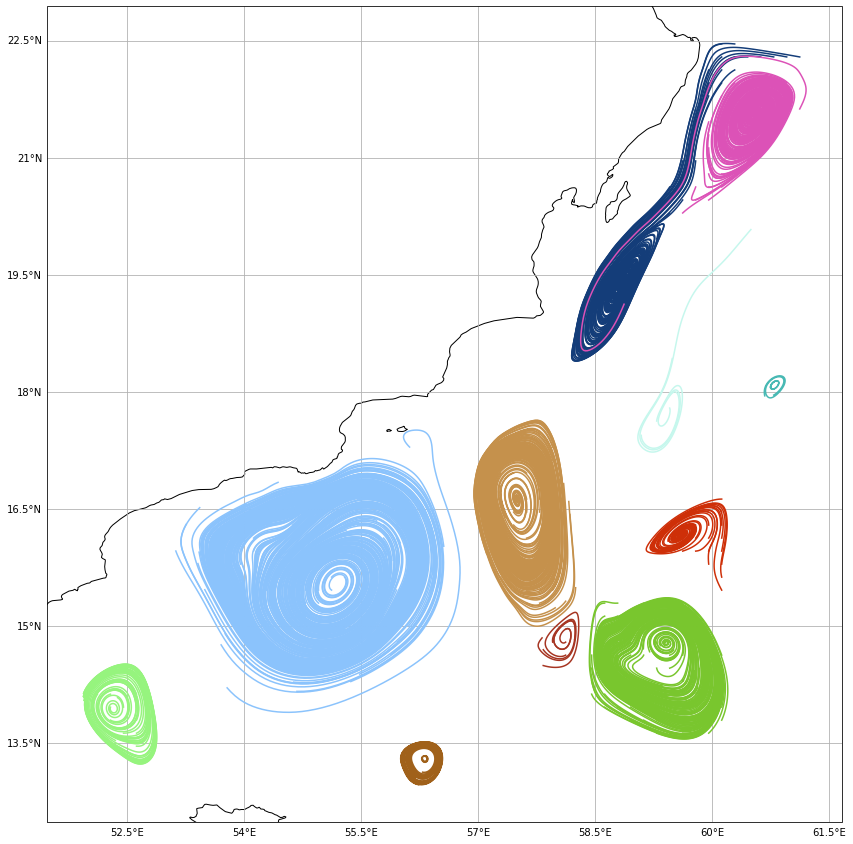

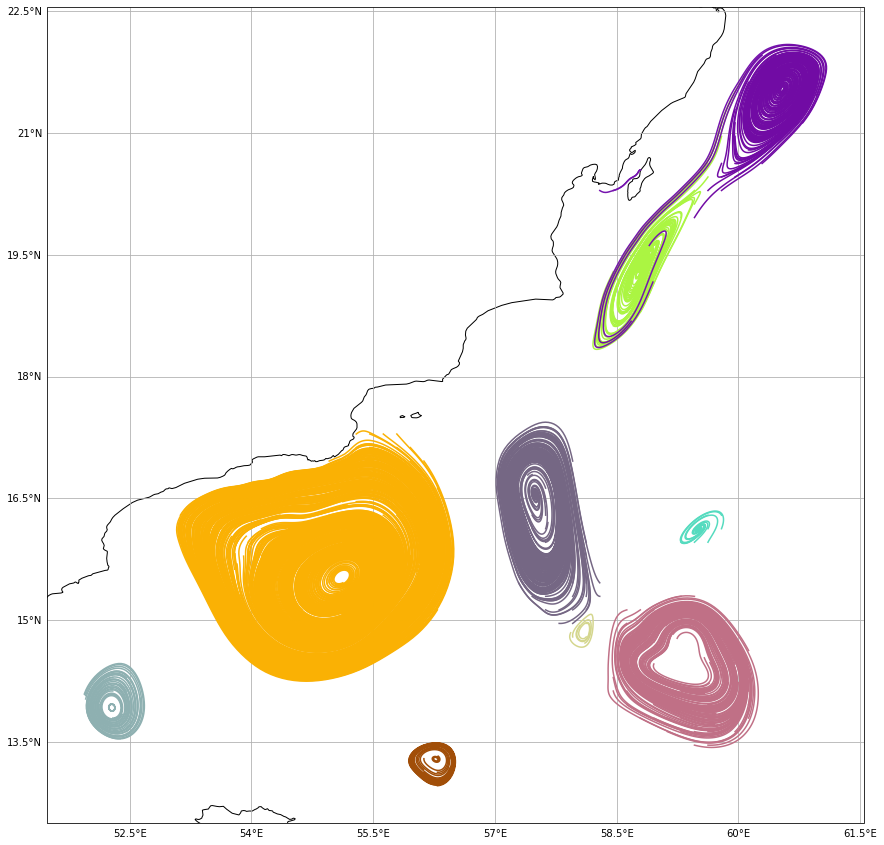

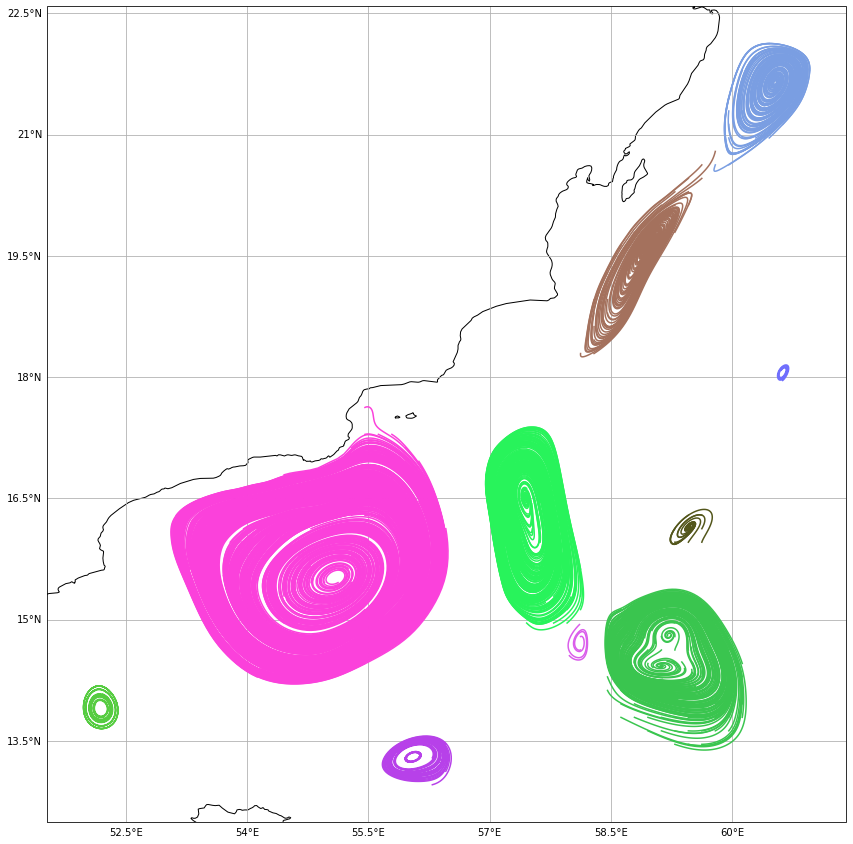

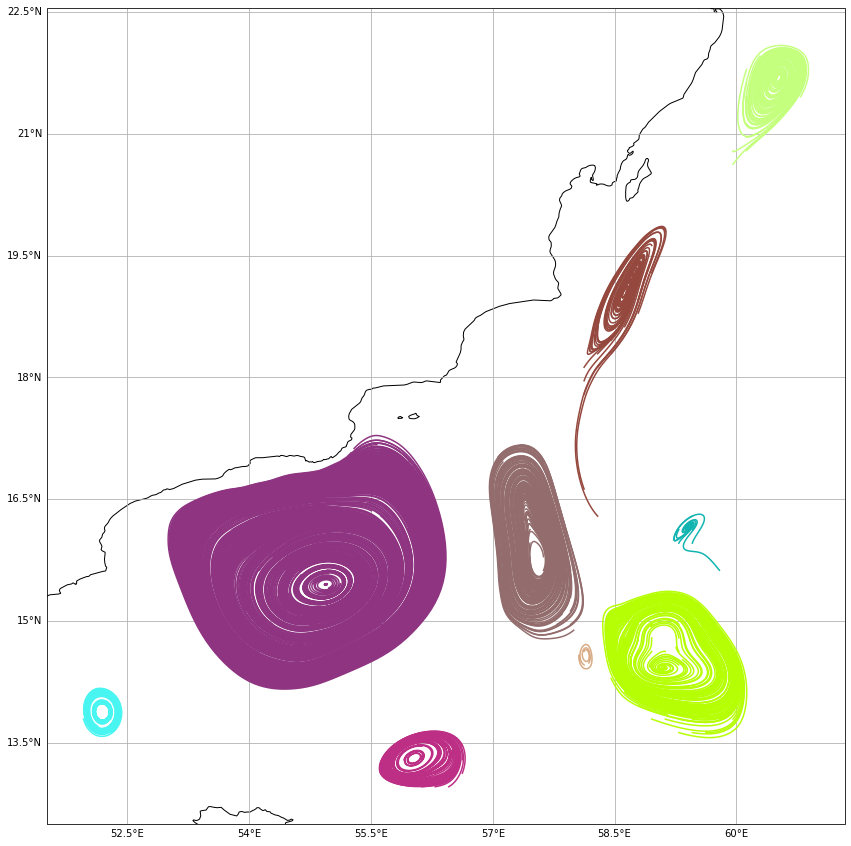

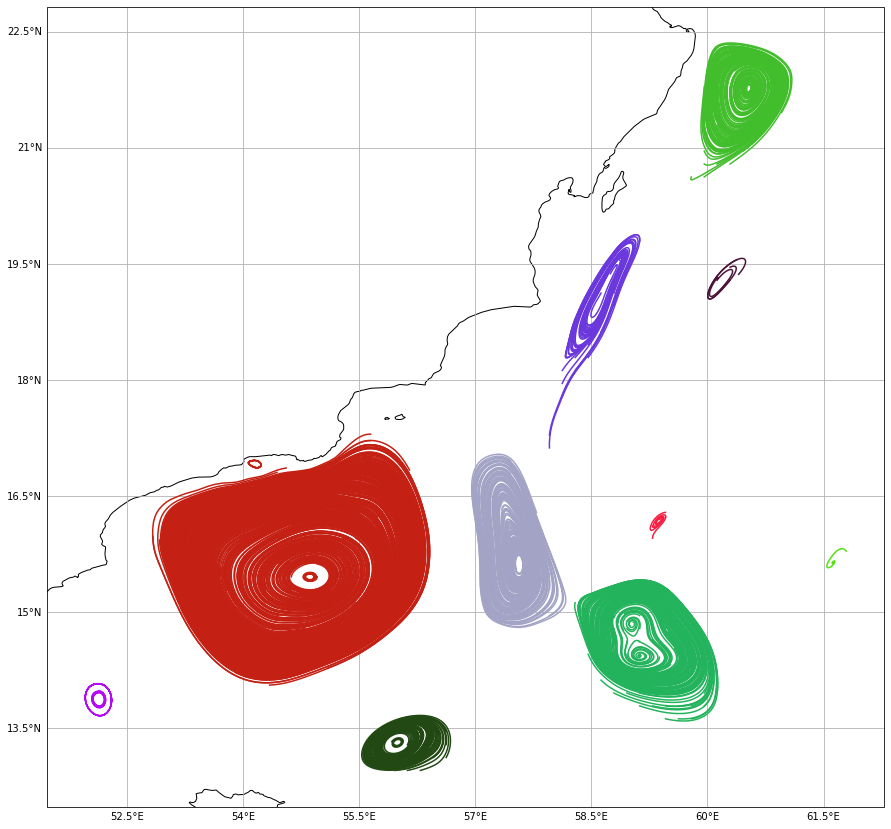

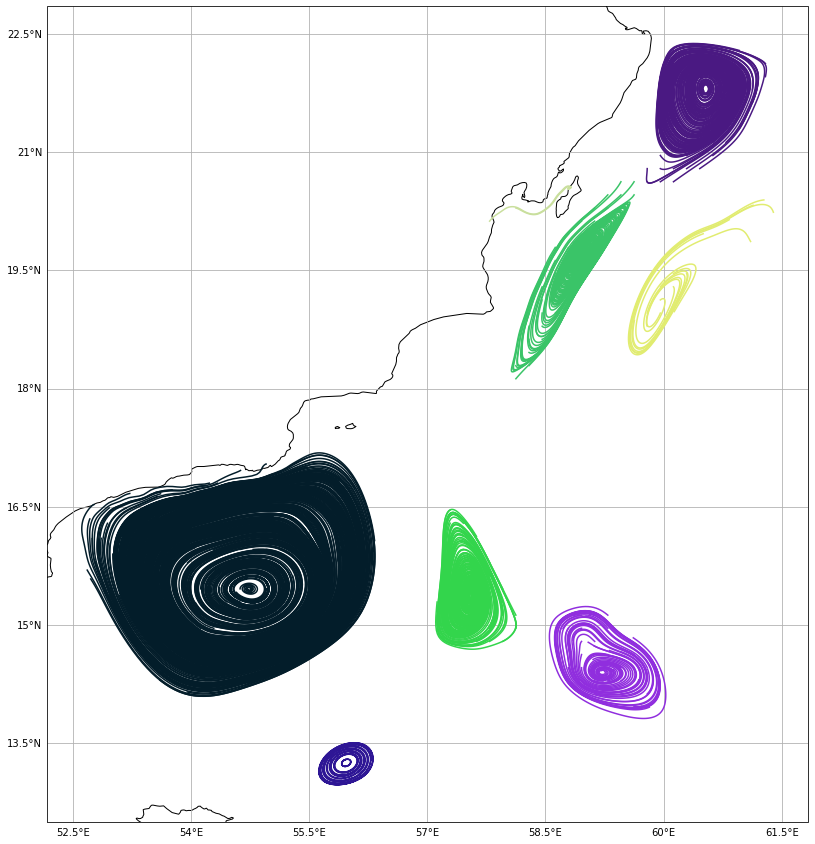

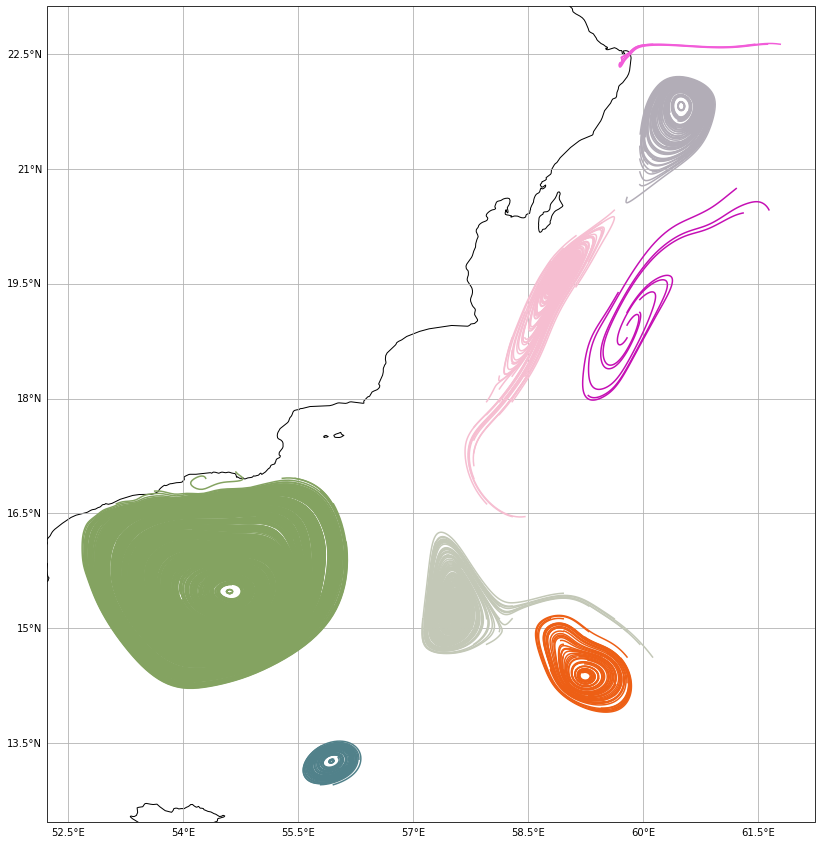

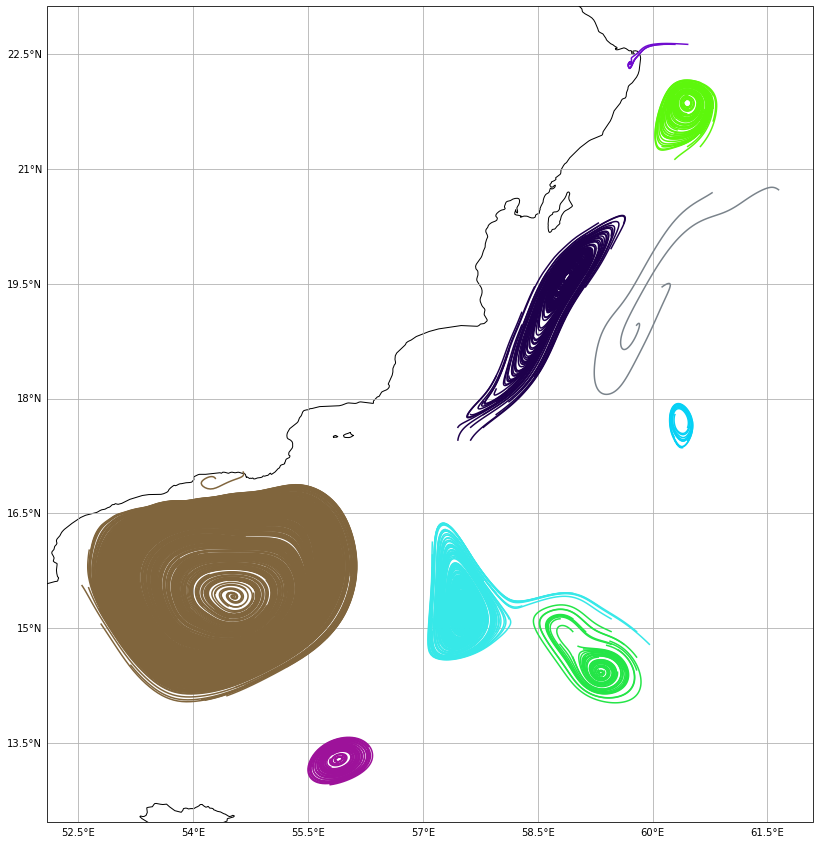

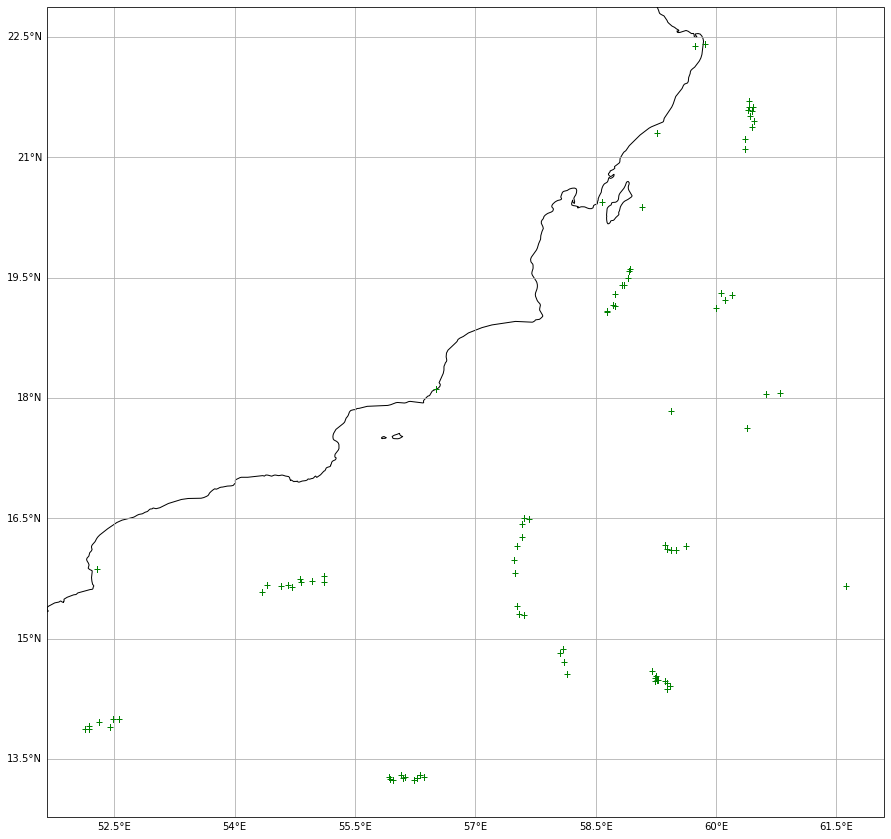

In [34]:
import random as rd


rd_color = lambda: '#{:02x}{:02x}{:02x}'.format(rd.randint(0,255),rd.randint(0,255),rd.randint(0,255))

for bb in list_path:
    figure = StreamPlot()
    for eddy in bb:
        line_style = rd_color()
        figure.plot_trajectories(eddy.sl_list,line_style=line_style)
    figure.show()

figure = StreamPlot()
for bb in list_path:
    figure.plot_eddies(bb,line_style='g+')

In [35]:
eddy = bb[0]
sl_list = eddy.sl_list
s = 0
n = 0
array_s = []
new_list_path = []
for bb in list_path:
    new_eddie = []
    n += len (bb)
    for eddy in bb:
        sl_list = eddy.sl_list
        s += len(sl_list)
        array_s.append(len(sl_list))
        if len(sl_list)>10:
            for i in sl_list:
                new_eddie.append(optimized_streamline(i,delta_time))

    new_bb = find_eddies(new_eddie)
    new_list_path.append(new_bb)

print("mean of the number of streamlines per eddies {}".format(s/n))

mean of the number of streamlines per eddies 54.05434782608695


In [36]:
p = array_s
print(min(p))
print(max(p))
print(np.quantile(p,[0.0,0.25,0.5,0.75,1.0]))

2
271
[  2.    7.5  31.5  67.  271. ]


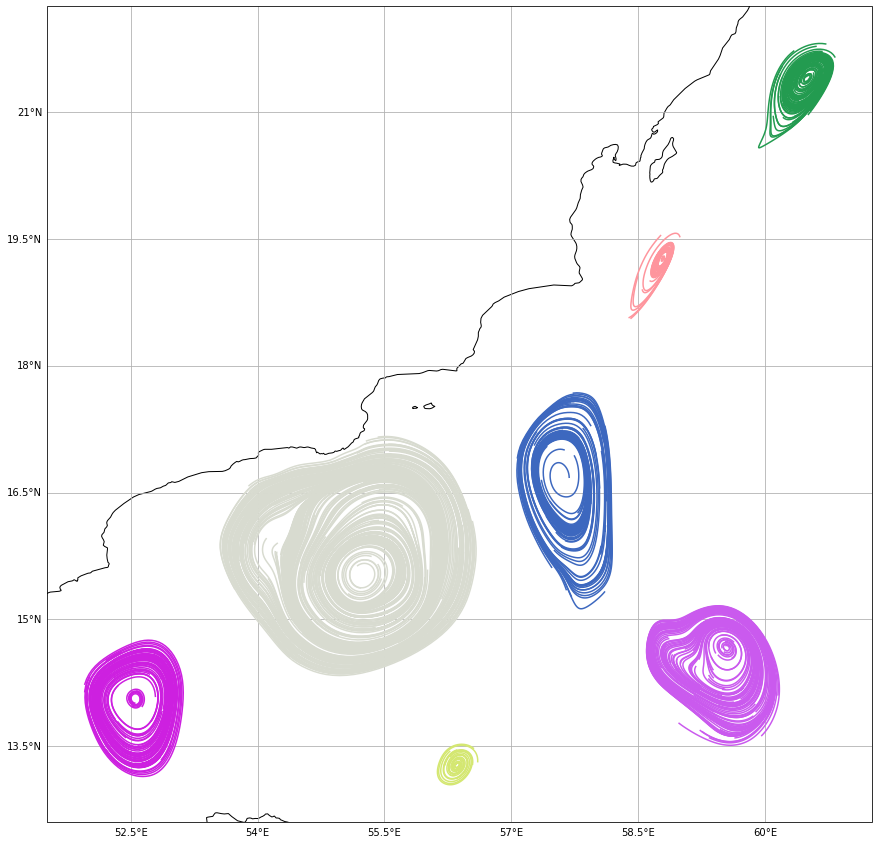

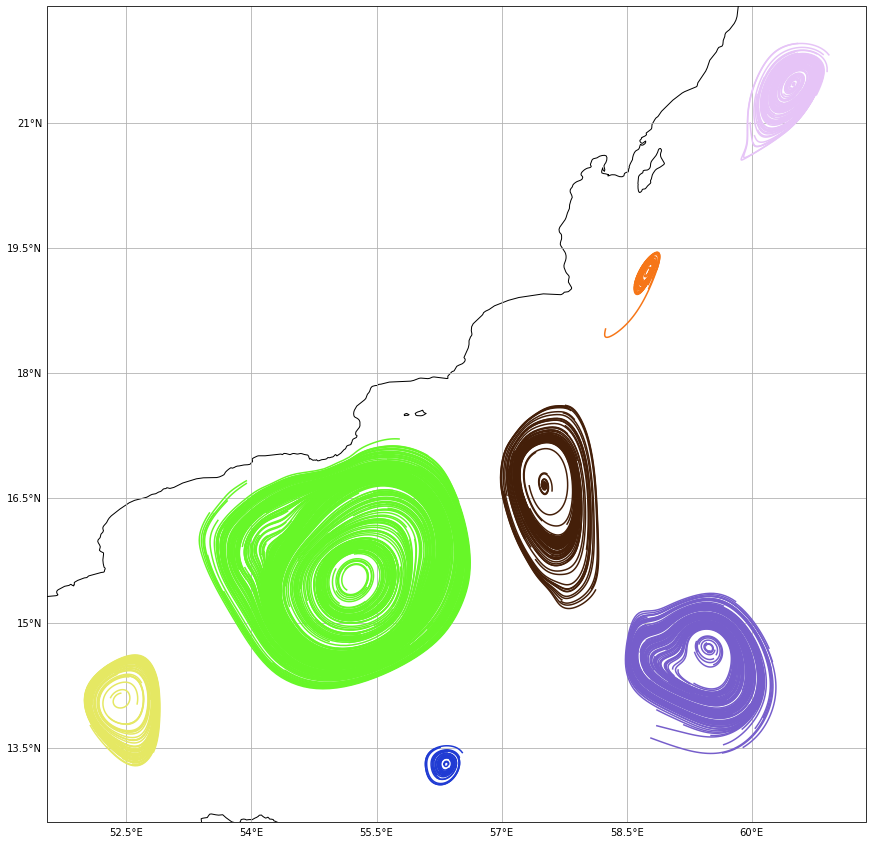

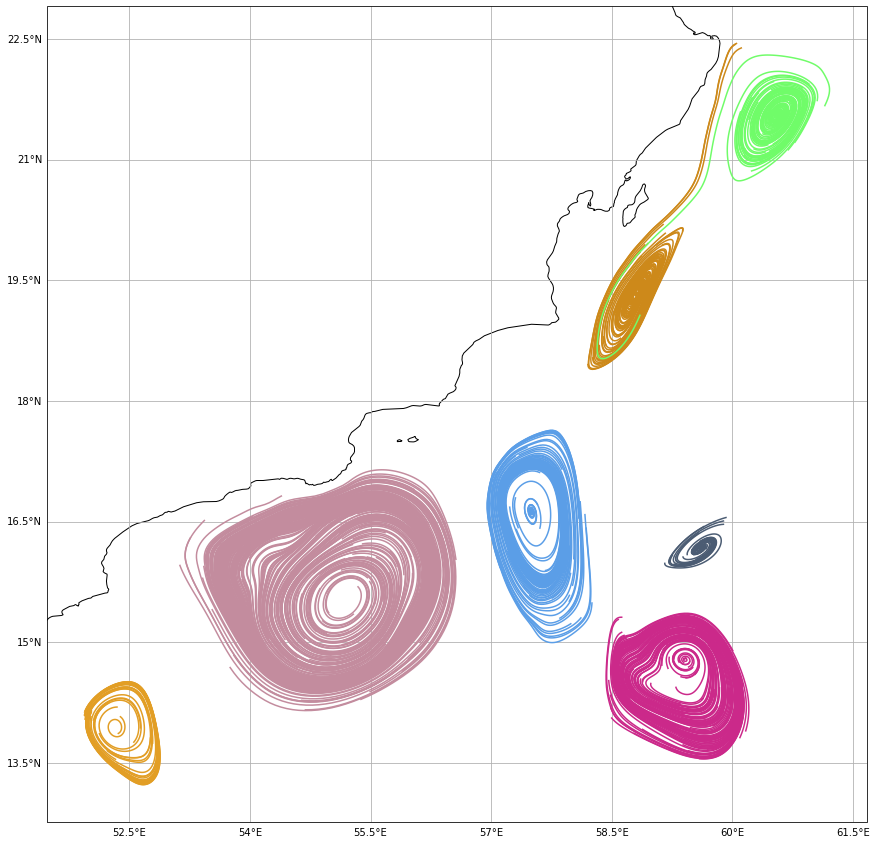

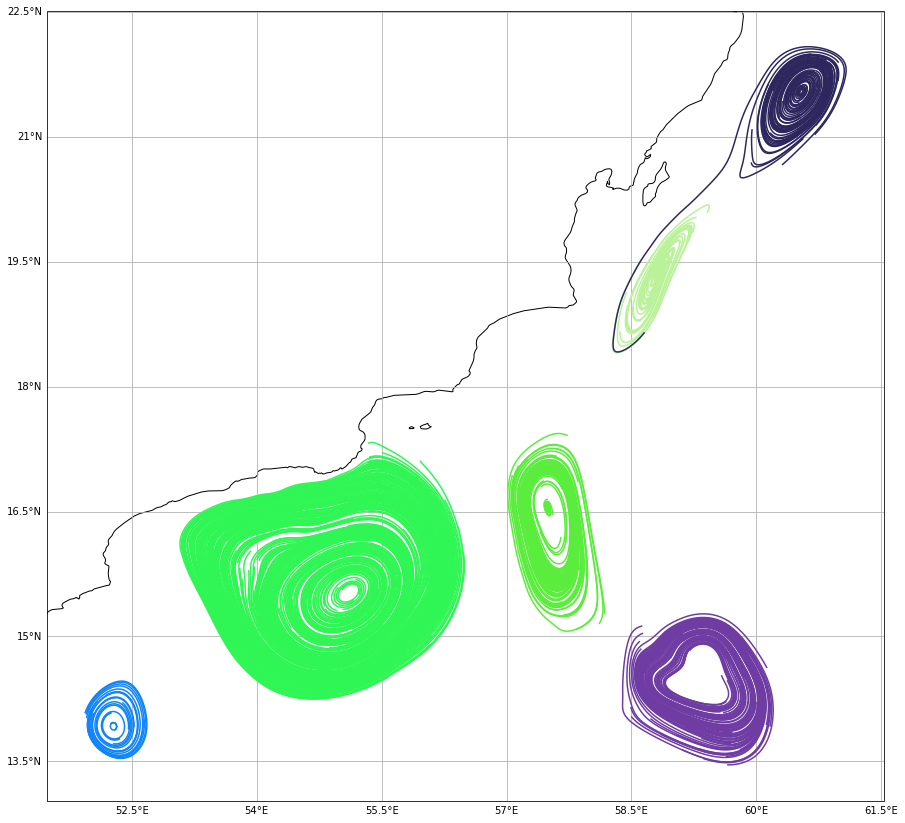

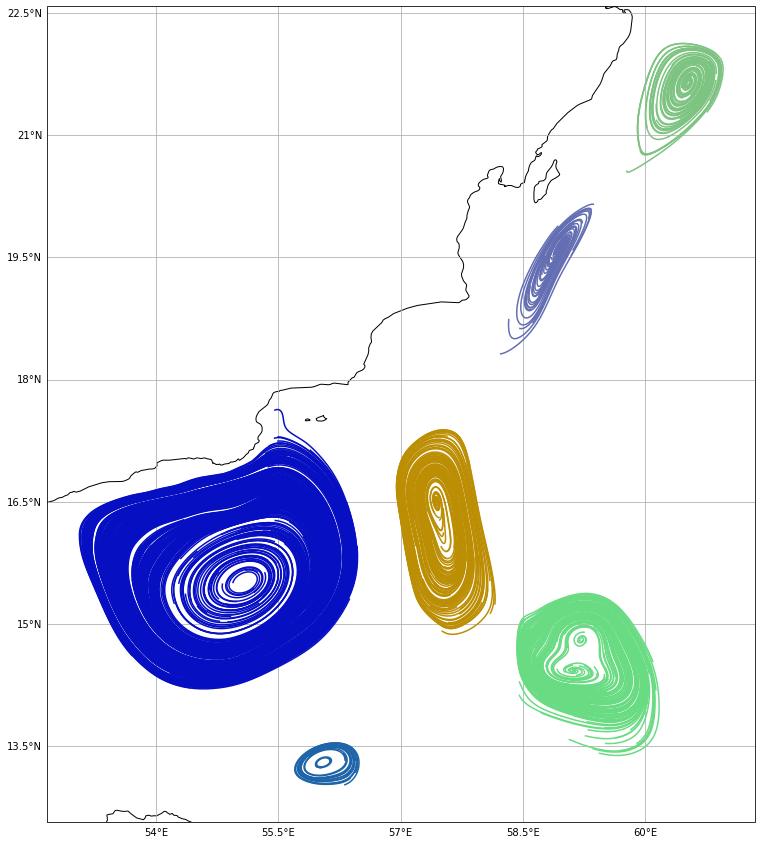

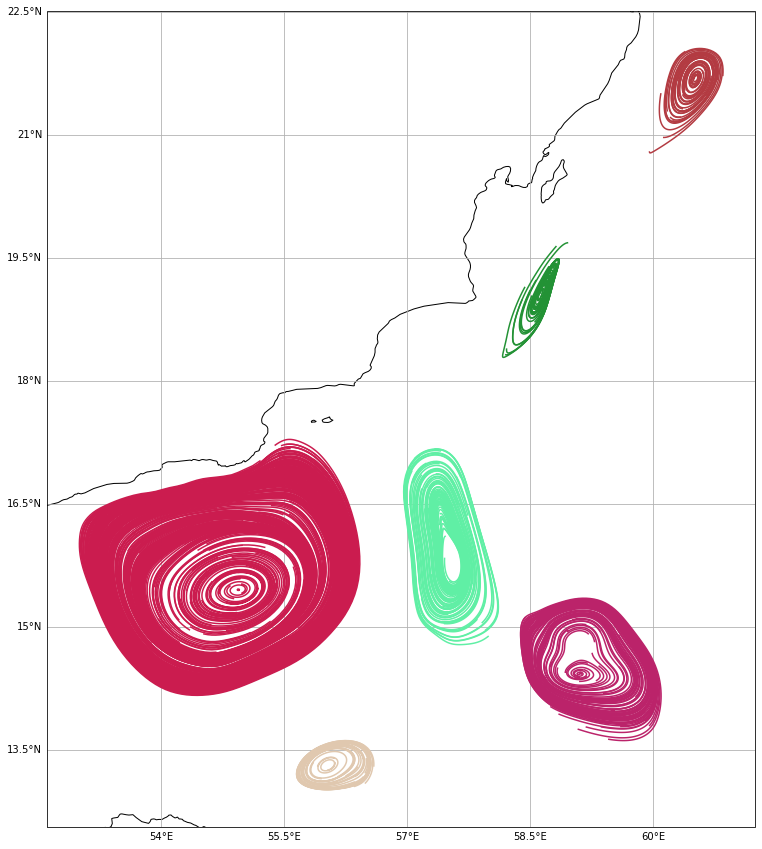

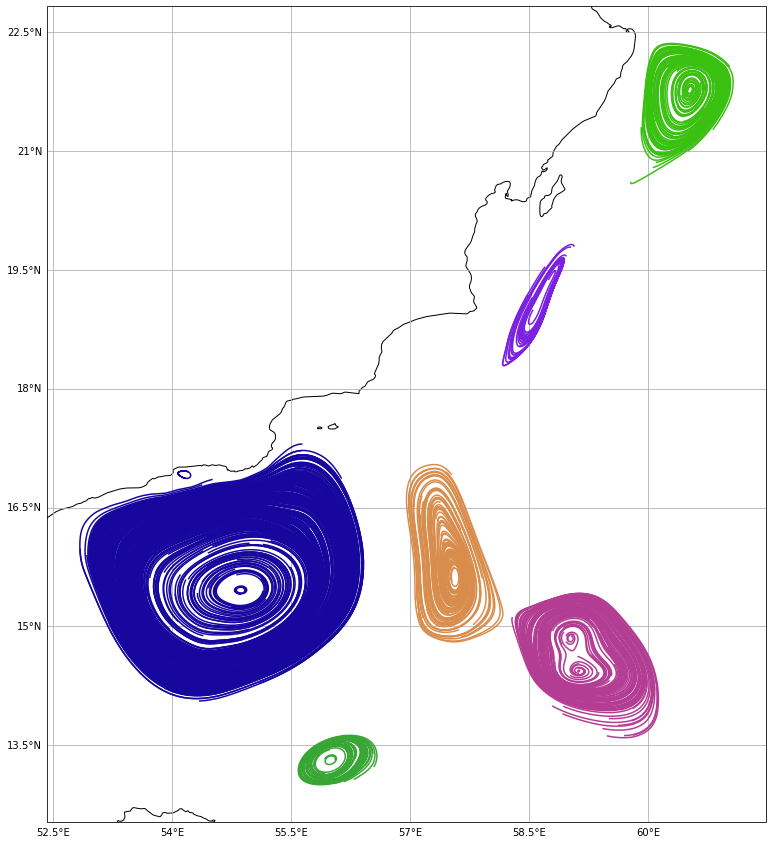

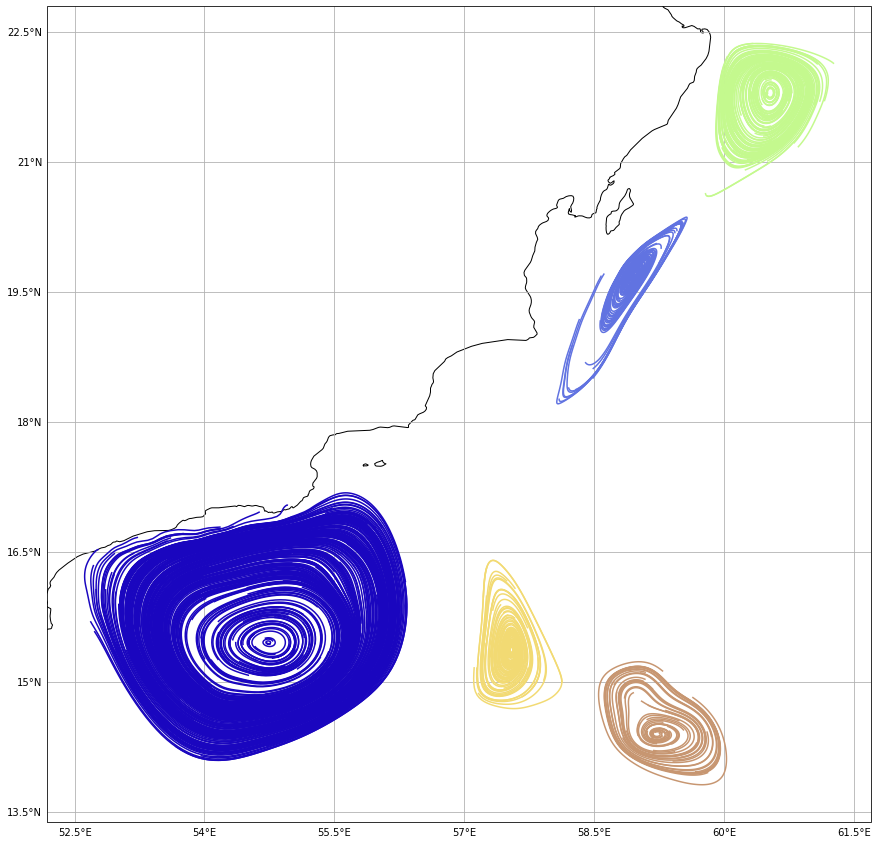

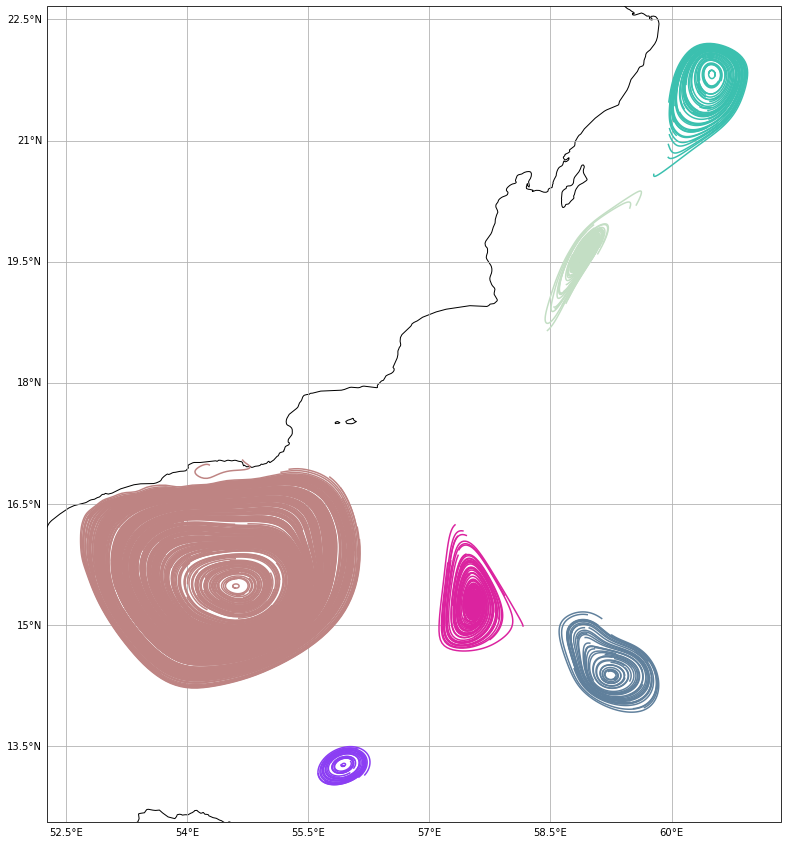

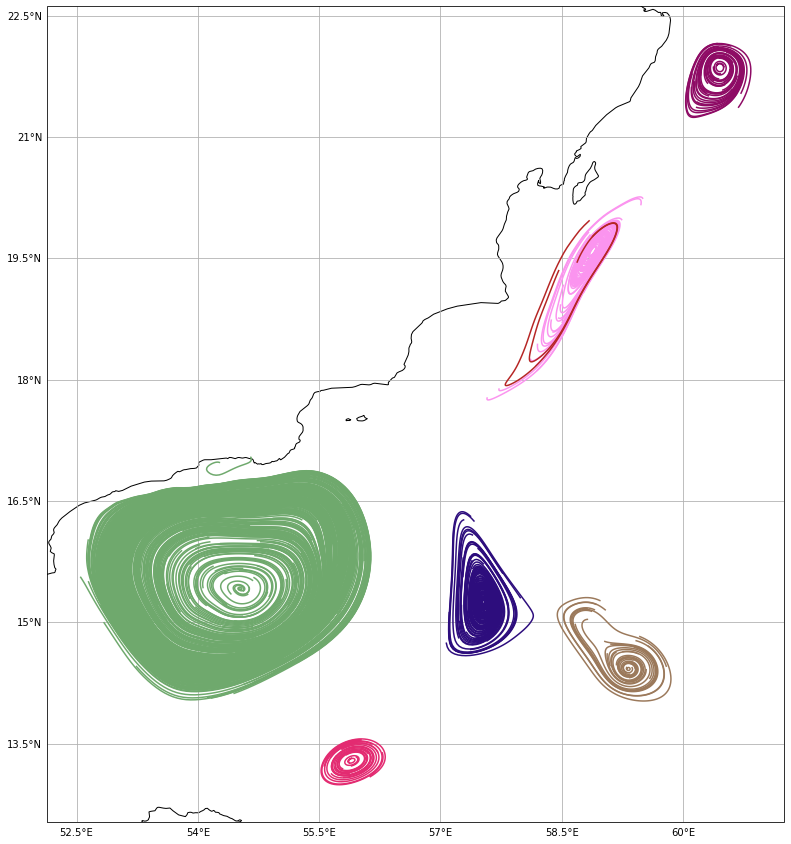

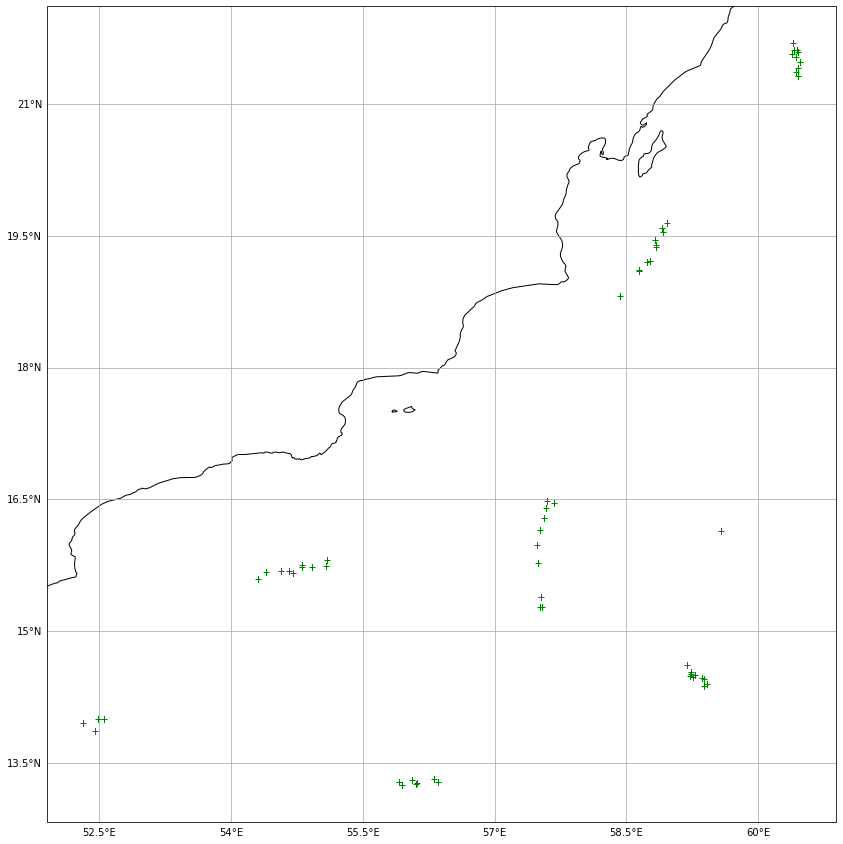

In [37]:
rd_color = lambda: '#{:02x}{:02x}{:02x}'.format(rd.randint(0,255),rd.randint(0,255),rd.randint(0,255))

for bb in new_list_path:
    figure = StreamPlot()
    for eddy in bb:
        line_style = rd_color()
        figure.plot_trajectories(eddy.sl_list,line_style=line_style)
    figure.show()

figure = StreamPlot()
for bb in new_list_path:
    figure.plot_eddies(bb,line_style='g+')

## Clustering

In [50]:
from math import *
def create_list_data(list_eddies):
    K = len(list_eddies[0])
    list_center = []
    for day in list_eddies:
        for eddies in day:
            list_center.append(eddies.center)
    return K,list_center


def calc_tho(l):
    S = np.array([0. for n in range(len(l[0]))])
    for x in l:
        S += np.array(x)
    return S/len(l)

def quadra_d (X,Y):
    S = 0
    for i in range(len(X)):
        S += (X[i]-Y[i])**2
    return sqrt(S)

def attrib_cluster(X,tho,d):
    distances = []
    for t in tho:
        distances.append(d(X,t))        
    i_min_d = distances.index(min(distances))
    return i_min_d


def Kmean(distance,list_eddies):
    K,list_center = create_list_data(list_eddies)
    
    cluster = [ [] for i in range(K)]
    tho = list_center[:K]

    tho = np.array(tho)
    tho_prime = np.zeros(tho.shape)
    tour = 0    
    
    while ( (tho_prime != tho).any() and tour<1000):
        tour += 1
        
        tho_prime = tho.copy()
        cluster = [ [] for i in range(K)]
        
        for day in list_eddies:
            for eddies in day:
                
                X = eddies.center
                i_min_d = attrib_cluster(X,tho,distance)
                cluster[i_min_d].append(X)
            
        for  i in range(K):
            tho[i] = calc_tho(cluster[i])
        
    return tho,cluster,tour

In [25]:
print(list_path[0][0].center)

[52.55596861 13.99970072]


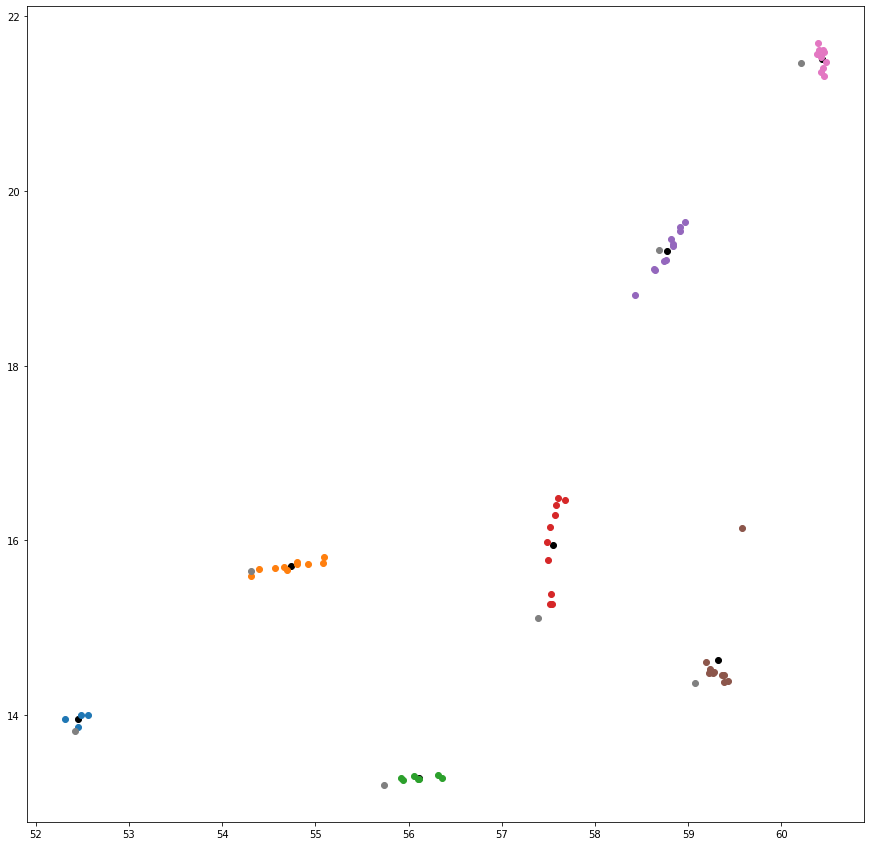

In [91]:
bary, cluster, tour = Kmean(quadra_d,new_list_path)
cluster1x = []
cluster1y = []
for i in bary:
    cluster1x.append(i[0])
    cluster1y.append(i[1])

plt.scatter(cluster1x,cluster1y, c = 'black' ) 

for cl in range(len(cluster)) :
    cluster1x = []
    cluster1y = []
    for i in cluster[cl]:
        cluster1x.append(i[0])
        cluster1y.append(i[1])

    plt.scatter(cluster1x,cluster1y )
n = cluster[0]
vect = []


for j in range(len(cluster)):
    n = cluster[j][:-1]
    for i in range(len(n)-1):
        vect.append(n[i+1]-n[i])
    vect_m = sum(vect)/len(n)
    newp = n[-1]+vect_m
    plt.scatter(newp[0], newp[1], color = 'grey')

[[array([52.55712243, 13.99675732]), array([52.49034447, 13.99950294]), array([52.45405717, 13.86403146]), array([52.31466953, 13.95112387])], [array([55.09015085, 15.80459344]), array([55.08426321, 15.74023573]), array([54.92511601, 15.73419219]), array([54.80646649, 15.73012291]), array([54.80897301, 15.75703805]), array([54.70041799, 15.65821556]), array([54.66071466, 15.69020229]), array([54.57266847, 15.68612935]), array([54.39613045, 15.67728646]), array([54.31125656, 15.59550124])], [array([56.35517543, 13.28426021]), array([56.31155559, 13.31138014]), array([56.09994116, 13.2630456 ]), array([56.11672048, 13.27378363]), array([56.06222602, 13.30057536]), array([55.94173643, 13.25137279]), array([55.91626015, 13.2842824 ])], [array([57.680415 , 16.4643783]), array([57.60195374, 16.48274175]), array([57.58480774, 16.40180021]), array([57.56638857, 16.28554973]), array([57.51879822, 16.14914945]), array([57.48567547, 15.97745698]), array([57.49831255, 15.77850028]), array([57.5294